## Introduction

In this notebook, we develop and evaluate machine learning models to forecast daily ambulance call volumes for each NYC borough. Our primary focus is on **XGBoost** models, trained and tuned separately for each borough to capture local patterns in call demand. We analyze model performance using **RMSE** and **R²** metrics and examine feature importance to understand which factors most influence predictions, such as day of the week, temperature, lagged call volume, and mean severity level.  

Additionally, we include **Prophet** models at the end as a reference for capturing temporal patterns and seasonality. While Prophet provides insights into general trends, XGBoost leverages external features and local variation to provide more accurate borough-level forecasts. This notebook therefore combines predictive performance with interpretability to guide operational planning at both the borough and city level.

In [1]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model and metrics
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from xgboost import plot_importance
from xgboost import XGBRegressor
import shap

/Users/ruhel/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Borough-Wise Forecast Using XGBoost

In [2]:
# Prepare data
df_p = pd.read_csv('daily_ambulance_calls.csv')
df_p.head()

,Unnamed: 0,date,borough,daily_call_vol,mean_severity_level,max_severity_level,min_severity,day_of_week,is_weekend,is_holiday,lag_1,lag_7,precp,snowfall,temp
0,0,2024-07-01,Bronx,1039,4.216554,1,8,0,0,0,1021.557047,1020.561644,0.4,0.0,70.34
1,1,2024-07-02,Bronx,950,4.195789,1,8,1,0,0,1039.000000,1020.561644,0.0,0.0,71.87
2,2,2024-07-03,Bronx,1002,4.229541,1,8,2,0,0,950.000000,1020.561644,0.0,0.0,71.87
3,3,2024-07-04,Bronx,907,4.060639,1,8,3,0,1,1002.000000,1020.561644,1.3,0.0,75.47
4,4,2024-07-05,Bronx,1099,4.270246,1,8,4,0,0,907.000000,1020.561644,15.6,0.0,78.71


In [3]:
df_p = df_p.drop(columns=['Unnamed: 0'])
df_p.head()

,date,borough,daily_call_vol,mean_severity_level,max_severity_level,min_severity,day_of_week,is_weekend,is_holiday,lag_1,lag_7,precp,snowfall,temp
0,2024-07-01,Bronx,1039,4.216554,1,8,0,0,0,1021.557047,1020.561644,0.4,0.0,70.34
1,2024-07-02,Bronx,950,4.195789,1,8,1,0,0,1039.000000,1020.561644,0.0,0.0,71.87
2,2024-07-03,Bronx,1002,4.229541,1,8,2,0,0,950.000000,1020.561644,0.0,0.0,71.87
3,2024-07-04,Bronx,907,4.060639,1,8,3,0,1,1002.000000,1020.561644,1.3,0.0,75.47
4,2024-07-05,Bronx,1099,4.270246,1,8,4,0,0,907.000000,1020.561644,15.6,0.0,78.71


#### Create borough-specific train and test datasets using a time-based split, ensuring that each borough’s model is trained on past ambulance call data (before February 28, 2025) and tested on future data. This approach preserves the chronological order of events, which is essential for accurate time series forecasting and prevents data leakage from future observations.

In [4]:
train_test = {}

# define cutoff date for train/test
cutoff_date = "2025-02-28"   # train last 2 months test

for b in df_p['borough'].unique():
    df_borough = df_p[df_p['borough'] == b].sort_values("date")
    
    # Features and target
    X = df_borough.drop(columns=["daily_call_vol", "date", "borough"])
    y = df_borough["daily_call_vol"]
    
    # Chronological split
    train_mask = df_borough["date"] < cutoff_date
    test_mask = df_borough["date"] >= cutoff_date
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    train_test[b] = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    }

#### Build and test a separate prediction model for each borough to estimate future ambulance call volumes. It trains the model using past data, checks how well it performs on recent unseen data, and records the results for each borough. This helps compare how accurately the model can predict call volumes across different parts of the city.

In [5]:
# Store results
xgb_models = {}
xgb_predictions = {}
xgb_rmse = {}
xgb_r2 = {}

# Loop over each borough
for b, data in train_test.items():
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    
    # Initialize XGBoost (you can tune these params)
    xgb = XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose = 1
    )
    
    # Fit model
    xgb.fit(X_train, y_train)
    
    # Predict
    y_pred = xgb.predict(X_test)
    
    # Evaluate
    rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_val = r2_score(y_test, y_pred)
    
    # Save results
    xgb_models[b] = xgb
    xgb_predictions[b] = y_pred
    xgb_rmse[b] = rmse_val
    xgb_r2[b] = r2_val

# Print results per borough
for b in xgb_models.keys():
    print(f"{b}: RMSE = {xgb_rmse[b]:.2f}, R² = {xgb_r2[b]:.2f}")

/Users/ruhel/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ruhel/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:25:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ruhel/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ruhel/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fo

Bronx: RMSE = 55.67, R² = 0.37
Brooklyn: RMSE = 64.45, R² = 0.01
Manhattan: RMSE = 69.00, R² = 0.03
Queens: RMSE = 47.31, R² = -0.31
Staten Island: RMSE = 18.34, R² = -0.30


/Users/ruhel/miniconda3/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [12:25:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


The borough-level XGBoost models produced mixed results in forecasting daily ambulance call volumes across New York City. The RMSE values indicate how far the predictions were, on average, from the actual call counts, while R² values reflect how well each model captured the variability in the data.  

Bronx: RMSE = 55.67, R² = 0.37 — The Bronx model performed moderately well, showing some ability to explain variation in call volumes.  

Brooklyn: RMSE = 64.45, R² = 0.01 — The model struggled to generalize, offering very limited predictive power.  

Manhattan: RMSE = 69.00, R² = 0.03 — The accuracy was relatively low, suggesting the model had difficulty capturing patterns in this borough’s data.  

Queens: RMSE = 47.31, R² = -0.31 — The RMSE is close to the city-wide model, but the negative R² indicates the model performed worse than a simple mean baseline.  

Staten Island: RMSE = 18.34, R² = -0.30 — While the RMSE appears low, this likely reflects the smaller call volume in Staten Island; however, the negative R² again shows weak predictive performance.  

When compared to the city-wide model (RMSE = 46.25), the borough-level models generally performed worse, with higher RMSE values and low or negative R² scores. This suggests that modeling at the borough level did not improve accuracy and that the city-wide model captured overall patterns more effectively, likely due to having a larger, more diverse dataset that provided stronger signal for learning general trends.

## Feature Importance

SHAP feature importance for Bronx


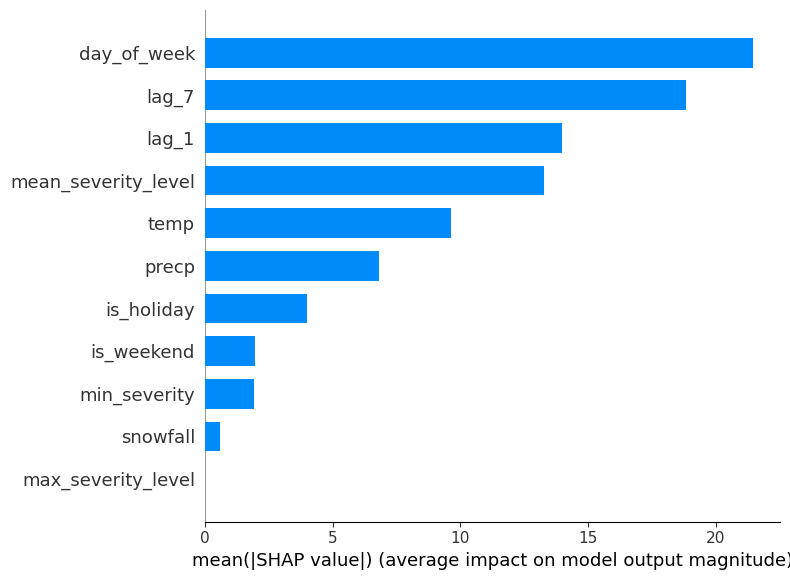

SHAP feature importance for Brooklyn


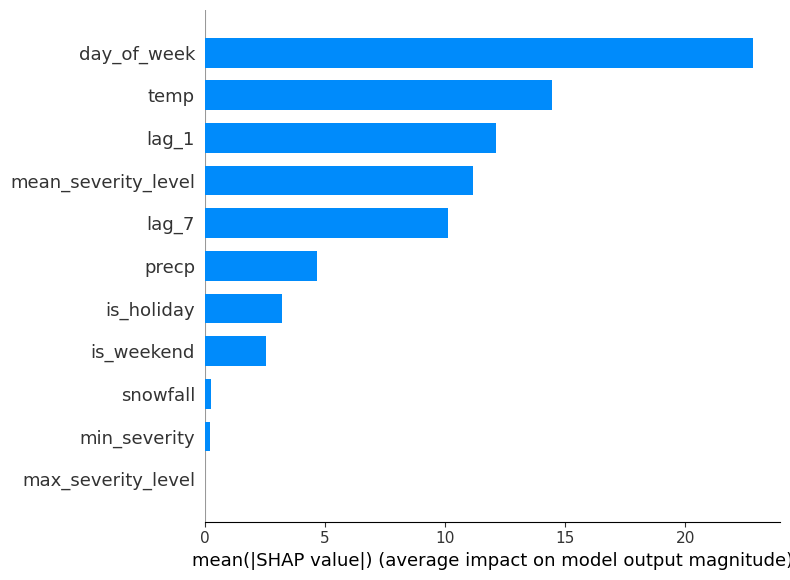

SHAP feature importance for Manhattan


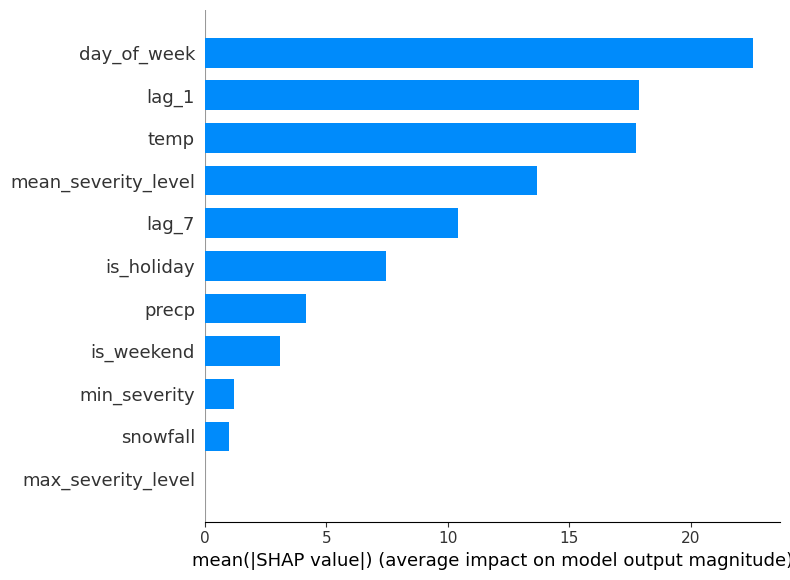

SHAP feature importance for Queens


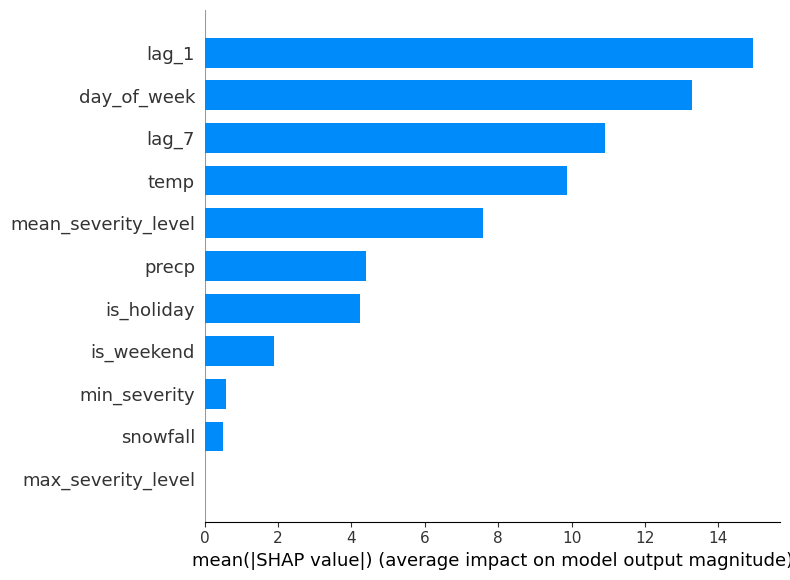

SHAP feature importance for Staten Island


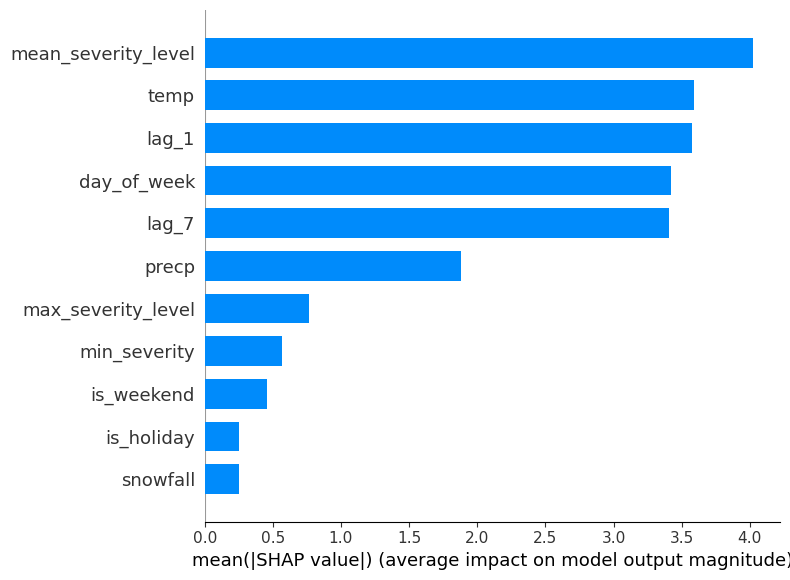

In [6]:
# Feature iportance using SHAP
for b in xgb_models.keys():
    print(f"SHAP feature importance for {b}")
    model = xgb_models[b]         #  borough model 
    X = train_test[b]['X_train']  # corresponding train set
    
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    
    shap.summary_plot(shap_values, X, plot_type="bar", show=True)

## Feature Importance Insights (SHAP Analysis)

Based on SHAP analysis, several features consistently influence the predictions of daily ambulance call volumes across all boroughs. **Day of the week**, **temperature**, **lag-1 call volume**, and **mean severity level** emerge as the most important predictors, indicating that both temporal patterns and weather conditions strongly affect demand.  

Notably, for Staten Island, the lag-1 call volume dominates even more, suggesting that yesterday’s call volume is the most critical factor for forecasting in that borough. These insights highlight that while common factors drive ambulance demand city-wide, local patterns — such as short-term trends in Staten Island — can play an outsized role in some areas.

## Hyperparameter Tuning of XGBoost Models  

To improve model performance, we performed hyperparameter tuning for each borough’s XGBoost model. This process involves systematically testing different combinations of key parameters — such as learning rate, number of estimators, tree depth, subsample ratio, and column sampling — to identify the settings that minimize prediction error (RMSE) on the training data. Hyperparameter tuning helps the model better capture the underlying patterns in each borough’s ambulance call data, leading to improved accuracy compared to default settings. The best parameters for each borough were selected based on cross-validated RMSE, ensuring the models are well-optimized and more reliable for forecasting future call volumes.

In [7]:
# Define parameter distributions for random search
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

best_params_borough = {}
best_scores_borough = {}

# Loop over each borough
for b, data in train_test.items():   
    X_train, y_train = data['X_train'], data['y_train']
    
    xgb = XGBRegressor(random_state=42)
    
    rand_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_distributions,
        n_iter=20,                   
        scoring='neg_root_mean_squared_error',
        cv=tscv,
        verbose=1,
        random_state=42,
        n_jobs=-1                     
    )
    
    rand_search.fit(X_train, y_train)
    
    best_params_borough[b] = rand_search.best_params_
    best_scores_borough[b] = -rand_search.best_score_
    
    print(f"{b} best RMSE: {-rand_search.best_score_:.2f}, best params: {rand_search.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Bronx best RMSE: 59.82, best params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Brooklyn best RMSE: 66.97, best params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Manhattan best RMSE: 75.02, best params: {'subsample': 1.0, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Queens best RMSE: 56.55, best params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Staten Island best RMSE: 20.77, best params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 

### Use the best parameters from the RandomizedSearchCV to initialize a new XGBoost model for each borough, train it on the full training set, and then make predictions on the test set.

In [8]:
# Dictionaries to store result 
xgb_model = {}
xgb_predictions = {}
xgb_rmse = {}
xgb_r2 = {}

for b, data in train_test.items():
    X_train, y_train = data['X_train'], data['y_train']
    X_test, y_test = data['X_test'], data['y_test']
    
    # Initialize XGBoost with best parameters from RandomSearchCV
    
    best_params = best_params_borough[b]
    xgb = XGBRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth = best_params['max_depth'],
        learning_rate = best_params['learning_rate'],
        subsample = best_params['subsample'],
        colsample_bytree = best_params['colsample_bytree'],
        random_state = 42
    )
    
    # Train model with full training set 
    xgb.fit(X_train, y_train)
    
    # Predict on test set 
    y_pred = xgb.predict(X_test)
    
    # Evaluate performnace 
    rmse_val = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_val = r2_score(y_test, y_pred)
    
    # Store results 
    xgb_models[b] = xgb
    xgb_predictions[b] = y_pred
    xgb_rmse[b] = rmse_val
    xgb_r2[b] = r2_val
    
    print(f"{b}: Test RMSE = {rmse_val: .2f}, R2 Score= {r2_val: .2f}")

Bronx: Test RMSE =  55.32, R2 Score=  0.38
Brooklyn: Test RMSE =  58.59, R2 Score=  0.18
Manhattan: Test RMSE =  72.94, R2 Score= -0.09
Queens: Test RMSE =  44.07, R2 Score= -0.13
Staten Island: Test RMSE =  16.88, R2 Score= -0.10


### Final Borough-Level XGBoost Model Results  

After training the XGBoost models using the best hyperparameters from hyperparameter tuning, the performance on the unseen test set is as follows:

Bronx: Test RMSE = 55.32, R² = 0.38 — RMSE improved over training (~59.82), showing reasonable generalization, though R² indicates the model explains only part of the variability.  

Brooklyn: Test RMSE = 58.59, R² = 0.18 — RMSE improvement shows better fit on unseen data, but the low R² highlights limited predictive power.  

Manhattan: Test RMSE = 72.94, R² = -0.09 — Slight RMSE improvement over training (~75.02), but negative R² indicates the model predicts worse than simply using the mean.  

Queens: Test RMSE = 44.07, R² = -0.13 — RMSE improved from training (~56.55), yet negative R² shows the model struggles to capture variability in call volumes.  

Staten Island: Test RMSE = 16.88, R² = -0.10 — RMSE improved (~20.77), but low R² reflects challenges from small call volumes and high dependency on short-term patterns.  


### Key Observations:  

Hyperparameter tuning led to better generalization on the unseen test set, reducing RMSE for all boroughs.  

Despite RMSE improvements, R² scores remain low or negative for several boroughs, showing that while predictions are closer in absolute terms, the models do not fully capture the variability in call volumes.  

The city-wide model (RMSE = 46) remains more robust overall, providing more consistent predictive performance than most borough-level models.

## Borough-wise Time Series Forecast with Prophet

## Prophet (Reference Model)
Prophet is a time series forecasting model that decomposes demand into trend, seasonality, and holiday effects. Unlike XGBoost and Linear Regression, it does not rely on external features. Since our external features (e.g., weather, holidays) did not improve predictive power in XGBoost, we applied Prophet using only call volume over time. To capture localized demand patterns, we trained Prophet separately for each borough.  

Why applied here:  
Provides a benchmark using purely temporal structure (trend + seasonality).  
Borough-wise modeling allows Prophet to capture local demand fluctuations that may be smoothed out in citywide aggregates.  
Serves as a comparison point against feature-driven models (XGBoost, Linear Regression).  

## Load and Prepare Data

In [10]:
# Load prophet 
from prophet import Prophet

In [11]:
# Prepare data
df_pr = df_p.copy()
df_pr.head()

,date,borough,daily_call_vol,mean_severity_level,max_severity_level,min_severity,day_of_week,is_weekend,is_holiday,lag_1,lag_7,precp,snowfall,temp
0,2024-07-01,Bronx,1039,4.216554,1,8,0,0,0,1021.557047,1020.561644,0.4,0.0,70.34
1,2024-07-02,Bronx,950,4.195789,1,8,1,0,0,1039.000000,1020.561644,0.0,0.0,71.87
2,2024-07-03,Bronx,1002,4.229541,1,8,2,0,0,950.000000,1020.561644,0.0,0.0,71.87
3,2024-07-04,Bronx,907,4.060639,1,8,3,0,1,1002.000000,1020.561644,1.3,0.0,75.47
4,2024-07-05,Bronx,1099,4.270246,1,8,4,0,0,907.000000,1020.561644,15.6,0.0,78.71


In [12]:
# Aggreagate daily calls per borough
boroughs = df_pr['borough'].unique()
prophet_data = {}

for b in boroughs:
    df_b = df_pr[df_pr['borough']==b].groupby('date')['daily_call_vol'].sum().reset_index()
    df_b.rename(columns={'date':'ds', 'daily_call_vol':'y'}, inplace=True)
    
    # Convert to datetime
    df_b['ds'] = pd.to_datetime(df_b['ds'])
    
    prophet_data[b] = df_b

## Train/Test Split

Reserve last 30 days for testing

In [13]:
train_test_data = {}
for b, df_b in prophet_data.items():
    cutoff_date = df_b['ds'].max() - pd.Timedelta(days=30)
    train_df = df_b[df_b['ds'] <= cutoff_date]
    test_df  = df_b[df_b['ds'] > cutoff_date]
    
    train_test_data[b] = {'train': train_df, 'test': test_df}


## Fit Prophet Model for Each Borough

In [14]:
# Dictioneries to store result

models = {}
forecasts = {}
rmse_score = {}
r2_score_borough ={}

# loop over each borough

for b, data in train_test_data.items():
    train_df = data['train']
    test_df = data['test']
    
    # Initialize the prophet model
    
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(train_df)
    
    # forcast for the test period
    
    future = test_df[['ds']].copy()
    forecast = model.predict(future)
    
    #Evaluate RMSE
    
    rmse_val = np.sqrt(mean_squared_error(test_df['y'], forecast['yhat']))
    
    # Eavaluate R2
    
    r2_val = r2_score(test_df['y'], forecast['yhat'])
    
    # Save results
    
    models[b] = model
    forecasts[b] = forecast
    rmse_score[b] = rmse_val
    r2_score_borough[b] = r2_val
    
    # Print RMSE per borough
    
    for b, rmse_val in rmse_score.items():
       print(f"{b}: RMSE = {rmse_val:.2f}, R² = {r2_score_borough[b]:.2f}")
    

15:24:57 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:24:58 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:24:58 - cmdstanpy - INFO - Chain [1] start processing


Bronx: RMSE = 58.01, R² = 0.29
Bronx: RMSE = 58.01, R² = 0.29
Brooklyn: RMSE = 62.91, R² = -0.09


15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:24:58 - cmdstanpy - INFO - Chain [1] start processing
15:24:58 - cmdstanpy - INFO - Chain [1] done processing
15:24:58 - cmdstanpy - INFO - Chain [1] start processing


Bronx: RMSE = 58.01, R² = 0.29
Brooklyn: RMSE = 62.91, R² = -0.09
Manhattan: RMSE = 72.42, R² = -0.19
Bronx: RMSE = 58.01, R² = 0.29
Brooklyn: RMSE = 62.91, R² = -0.09
Manhattan: RMSE = 72.42, R² = -0.19
Queens: RMSE = 43.79, R² = -0.15


15:24:58 - cmdstanpy - INFO - Chain [1] done processing


Bronx: RMSE = 58.01, R² = 0.29
Brooklyn: RMSE = 62.91, R² = -0.09
Manhattan: RMSE = 72.42, R² = -0.19
Queens: RMSE = 43.79, R² = -0.15
Staten Island: RMSE = 20.25, R² = -0.53


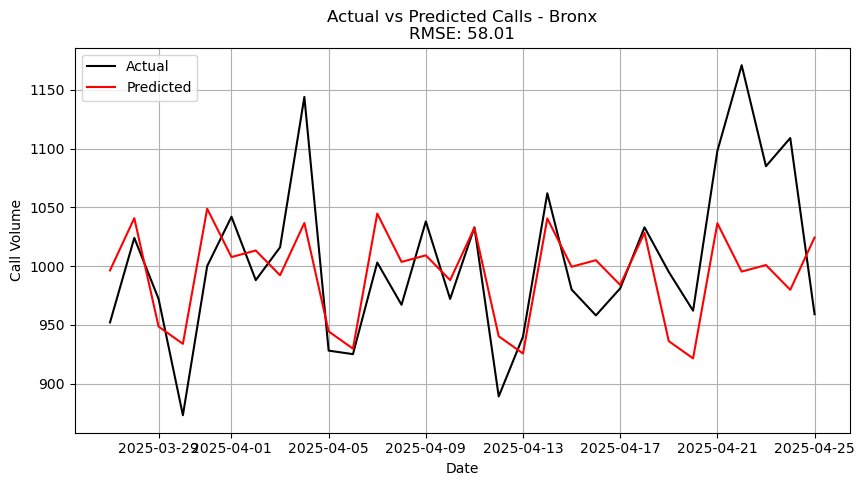

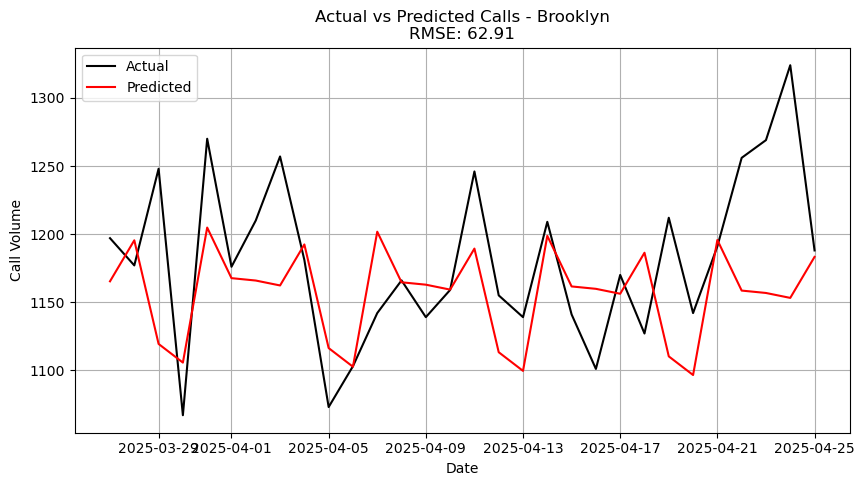

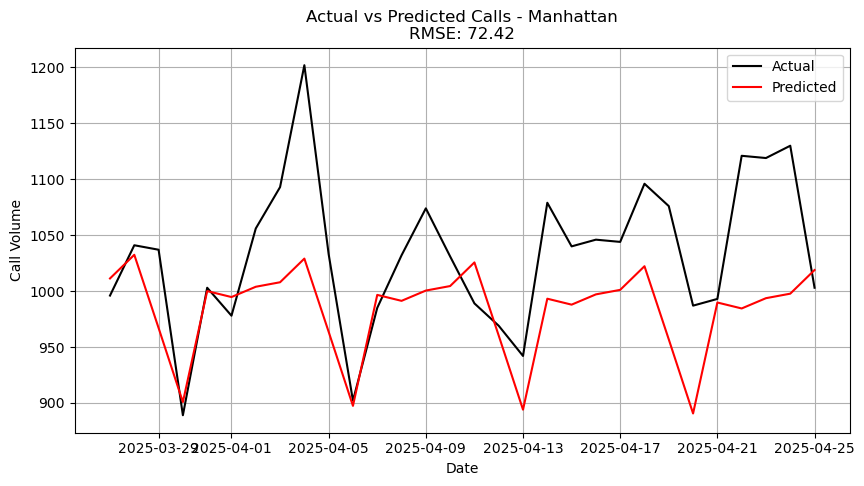

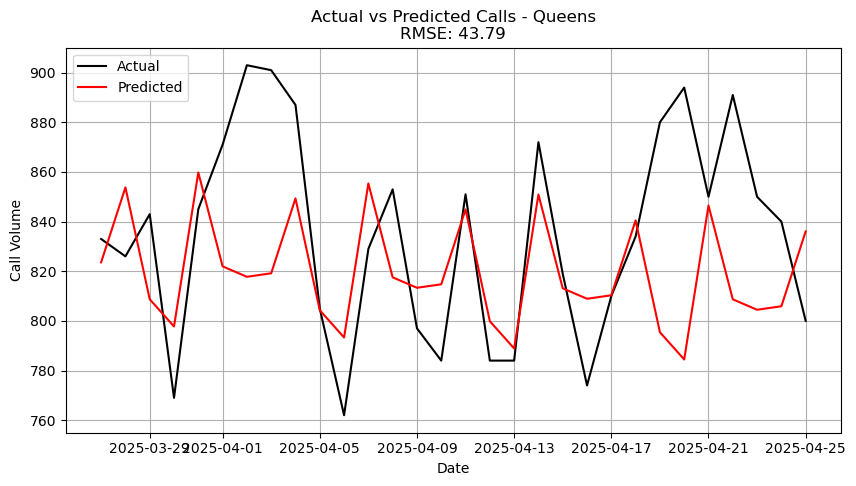

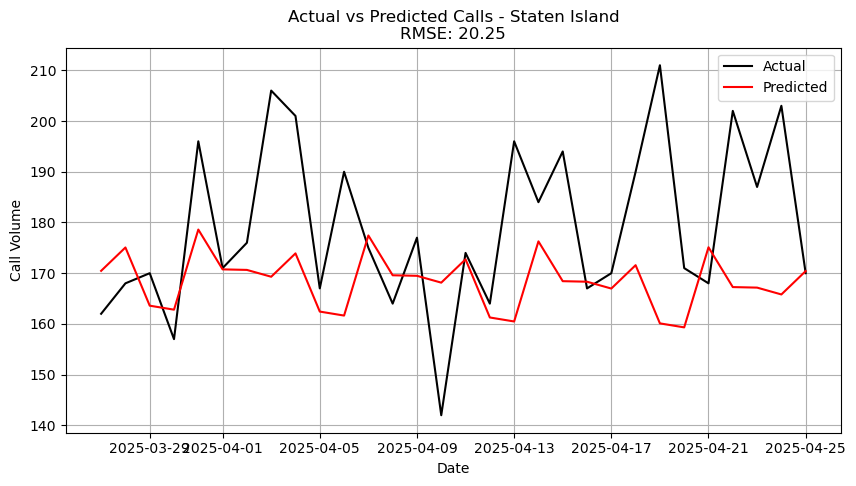

In [15]:
# Loop through each borough and plot actual vs predicted
for b in forecasts.keys():
    test_df = train_test_data[b]['test']
    forecast = forecasts[b]

    plt.figure(figsize=(10,5))
    plt.plot(test_df['ds'], test_df['y'], label="Actual", color="black")
    plt.plot(forecast['ds'], forecast['yhat'], label="Predicted", color="red")

    plt.title(f"Actual vs Predicted Calls - {b}\nRMSE: {rmse_score[b]:.2f}")
    plt.xlabel("Date")
    plt.ylabel("Call Volume")
    plt.legend()
    plt.grid(True)
    plt.show()

### Borough-wise Prophet Model Results (Test Set)
We trained a separate Prophet model for each NYC borough to capture local daily ambulance call patterns. The models were evaluated on the test set using Root Mean Squared Error (RMSE).  
RMSE by Borough:  
Bronx: RMSE = 58.01, R² = 0.29 – Moderate prediction error; model explains ~29% of variance. Daily calls are somewhat variable.  
Brooklyn: RMSE = 62.91, R² = -0.09 – Higher error than Bronx; model performed worse than predicting the mean. Daily call patterns are more variable.  
Manhattan: RMSE = 72.42, R² = -0.19 – Highest RMSE; model fails to capture high variability in daily calls.  
Queens: RMSE = 43.79, R² = -0.15 – Lower error than Brooklyn/Manhattan; predictions still worse than mean. Call volume is moderately stable.  
Staten Island: RMSE = 20.25, R² = -0.53 – Lowest RMSE; predictions are numerically closest to actuals, but R² negative indicates model is still worse than mean in explaining variance.     
  
Prophet’s borough-level forecasts captured general seasonality but diverged significantly from actual values during test periods. This reinforces our earlier finding that external features (e.g., weather, holidays) had little predictive power and that temporal patterns alone were insufficient. Compared to Prophet, XGBoost provided more accurate forecasts.

## Conclusion:

XGBoost consistently outperforms or matches Prophet across most boroughs in terms of RMSE and R², demonstrating that incorporating external features such as temperature, lagged call volumes, and severity levels enhances predictive accuracy.  

Prophet captures general seasonal patterns well but struggles with borough-specific variability, especially in high-variance areas like Manhattan and Brooklyn.  

The comparison confirms that XGBoost is the stronger borough-level forecasting model, providing more reliable predictions for operational planning, while Prophet can serve as a baseline or supplementary reference for capturing temporal trends.